## Model Pipeline Structure

#### Funcitons we need
1. Feature selector
    a. function to make the basic feature we always use
    b. function to add the new features we make to the main df/array
2. Model cross validator
    a. Can take a different model and return cross validations
    b. Can grid search on parmaters
3. Model ensemble predictions
    a. Makes predictions on multiple folds and averages them per model

In [9]:
# from comet_ml import Experiment
    
# # Add the following code anywhere in your machine learning file
# experiment = Experiment(api_key="gBHDDs5I5XQ8SwfIiLMK5fKMx",
#                         project_name="ashre", workspace="nicholasjhana")

import numpy as np
import pandas as pd
import gc
from time import gmtime, strftime


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest

from scipy.stats import mode


import datetime
#from meteocalc import feels_like, Temp


import lightgbm as lgb
# import comet_ml in the top of your file

from collections import defaultdict

/Users/ns/anaconda3/envs/ashrae-energy-prediction/lib/python3.6/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [11]:
#Based on this great kernel https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",df[col].dtype)            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            print("min for this col: ",mn)
            print("max for this col: ",mx)
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",df[col].dtype)
            print("******************************")
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return df, NAlist

### Loading Data Functions

In [12]:
def load_train_data(path='/Users/ns/code/nicholasjhana/ashrae-energy-prediction/data/'):
    
    #load train datasets and inital size
    building_df = pd.read_csv(path + "building_metadata.csv")
    weather_train = pd.read_csv(path + "weather_train.csv")
    train = pd.read_csv(path + "train.csv")
    print('inital load {}'.format(train.shape))
    
    return train, building_df, weather_train

In [13]:
def load_test_data(path='/Users/ns/code/nicholasjhana/ashrae-energy-prediction/data/'):
    
    #load the test datasets
    building_df = pd.read_csv(path + "building_metadata.csv")
    weather_test = pd.read_csv(path + "weather_test.csv")
    test = pd.read_csv(path + "test.csv")
    
    #check the size
    print('inital load {}'.format(test.shape))
    
    return test, building_df, weather_test

In [ ]:
 
    #add additional features
    weather_train = make_weather_features(weather_train)
    building_df = transform_floors_to_bins(building_df)
    
    #merge train and building id data and check size
    train = train.merge(building_df, 
                        left_on = "building_id", 
                        right_on = "building_id", 
                        how = "left")
    print("after building df load {}".format(train.shape))
    
    #merge train and weather_train data and check size
    train = train.merge(weather_train, 
                        left_on = ["site_id", "timestamp"], 
                        right_on = ["site_id", "timestamp"],
                        how = "left")
    print("after weather load {}".format(train.shape))

In [113]:
train, building_df, weather_train = load_train_data()
test, building_df, weather_test = load_test_data()

inital load (20216100, 4)
inital load (41697600, 4)


In [94]:
weather_train.isnull().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64

## Drop bad Rows
See this notebook: https://www.kaggle.com/kyakovlev/ashrae-lgbm-simple-fe

In [14]:
def drop_bad_rows(train):
    # Ref 1
    train_df = train[train['building_id'] != 1099 ]
    # Ref 2
    train_df = train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')
    
    return train_df

In [106]:
train_df.shape, train.shape

((19852422, 4), (20216100, 4))

### Weather Features Creation

Function modified from https://www.kaggle.com/roydatascience/ashrae-energy-prediction-using-stratified-kfold

In [15]:
def fill_weather_dataset(weather_df):
    
    # Find Missing Dates
    time_format = "%Y-%m-%d %H:%M:%S"
    start_date = datetime.datetime.strptime(weather_df['timestamp'].min(),time_format)
    end_date = datetime.datetime.strptime(weather_df['timestamp'].max(),time_format)
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

    for site_id in range(16):
        site_hours = np.array(weather_df[weather_df['site_id'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
        new_rows['site_id'] = site_id
        weather_df = pd.concat([weather_df,new_rows], axis=0)

        weather_df = weather_df.reset_index(drop=True)           

    # Add new time Features
    weather_df["datetime"] = pd.to_datetime(weather_df["timestamp"])
    weather_df["day"] = weather_df["datetime"].dt.day
    weather_df["week"] = weather_df["datetime"].dt.week
    weather_df["month"] = weather_df["datetime"].dt.month
    
    # Reset Index for Fast Update
    weather_df = weather_df.set_index(['site_id','day','month'])

    print(weather_df.info())

    air_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])
    weather_df.update(air_temperature_filler,overwrite=False)

    # Step 1
    cloud_coverage_filler = weather_df.groupby(['site_id','day','month'])['cloud_coverage'].min()
    # Step 2
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'),columns=["cloud_coverage"])

    weather_df.update(cloud_coverage_filler,overwrite=False)
    
    due_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
    weather_df.update(due_temperature_filler,overwrite=False)

    
    # Step 1
    sea_level_filler = weather_df.groupby(['site_id','day','month'])['sea_level_pressure'].mean()
    # Step 2
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'),columns=['sea_level_pressure'])
    weather_df.update(sea_level_filler,overwrite=False)
    #convert sea_level_pressure to int
    weather_df['sea_level_pressure'] = weather_df['sea_level_pressure'].astype('int')

    wind_direction_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_direction'].mean(),columns=['wind_direction'])
    weather_df.update(wind_direction_filler,overwrite=False)

    wind_speed_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_speed'].mean(),columns=['wind_speed'])
    weather_df.update(wind_speed_filler,overwrite=False)

    # Step 1
    precip_depth_filler = weather_df.groupby(['site_id','day','month'])['precip_depth_1_hr'].mean()
    # Step 2
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'),columns=['precip_depth_1_hr'])
    weather_df.update(precip_depth_filler,overwrite=False)

    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime','day','week','month'],axis=1)
    
    def get_meteorological_features(data):
        def calculate_rh(df):
            df['relative_humidity'] = 100 * (np.exp((17.625 * df['dew_temperature']) / (243.04 + df['dew_temperature'])) / np.exp((17.625 * df['air_temperature'])/(243.04 + df['air_temperature'])))
#         def calculate_fl(df):
#             flike_final = []
#             flike = []
#             # calculate Feels Like temperature
#             for i in range(len(df)):
#                 at = df['air_temperature'][i]
#                 rh = df['relative_humidity'][i]
#                 ws = df['wind_speed'][i]
#                 flike.append(feels_like(Temp(at, unit = 'C'), rh, ws))
#             for i in range(len(flike)):
#                 flike_final.append(flike[i].f)
#             df['feels_like'] = flike_final
#             del flike_final, flike, at, rh, ws
        calculate_rh(data)
#         calculate_fl(data)
        return data

    weather_df = get_meteorological_features(weather_df)
    return weather_df

In [97]:
weather_train.shape

(139773, 9)

In [101]:
weather_train = fill_weather_dataset(weather_train)

/Users/ns/anaconda3/envs/ashrae-energy-prediction/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


In [138]:
weather_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int64
timestamp             139773 non-null object
air_temperature       139718 non-null float64
cloud_coverage        70600 non-null float64
dew_temperature       139660 non-null float64
precip_depth_1_hr     89484 non-null float64
sea_level_pressure    129155 non-null float64
wind_direction        133505 non-null float64
wind_speed            139469 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.6+ MB


### FEATURE ENGINEERING
Modified from https://www.kaggle.com/roydatascience/ashrae-energy-prediction-using-stratified-kfold

In [16]:
def features_engineering(df, is_test_set=False, dict_LabelEncoder=None):
    
    # Sort by timestamp
    df.sort_values("timestamp")
    df.reset_index(drop=True)
    
    # Add more features
    df["timestamp"] = pd.to_datetime(df["timestamp"],format="%Y-%m-%d %H:%M:%S")
    df["hour"] = df["timestamp"].dt.hour
    df["dayofweek"] = df["timestamp"].dt.dayofweek
    
    df['month'] = df['timestamp'].dt.month
    df['month'].replace((11, 12, 1, 2), 1, inplace = True)
    df['month'].replace((6, 7, 8, 9), 2, inplace = True)
    df['month'].replace((3, 4, 5, 10), 3, inplace = True)
    
    df['square_feet_log'] =  np.log1p(df['square_feet'])
    
    # Remove Unused Columns
    drop = ["timestamp"]
    df = df.drop(drop, axis=1)
    gc.collect()
    
    #trasform the target column
#     if not is_test_set:
#         df['meter_reading'] = np.log1p(df["meter_reading"])
    
    label_cols = ['floor_count', 'wind_direction', 'primary_use']
    print(label_cols)
    
    #transform floor count to bins
    bins = [0,2,6,11,np.inf]
    floor_labels = ['single', 'low', 'mid', 'high-rise']
    df['floor_count'] = pd.cut(df['floor_count'], bins, labels=floor_labels).astype('str')
    
    #transform wind directions to ordinal N,W,S,E
    bins = [0, 45, 135, 225, 315, 365]
    wind_labels = ['north', 'east', 'south', 'west', 'n']
    df['wind_direction'] = pd.cut(df['wind_direction'], bins, labels=wind_labels).astype('str')
    df['wind_direction'].replace('n', 'north', inplace=True)
    
    if is_test_set:
        try:
            label_cols = list(dict_LabelEncoder.keys())
            df[label_cols] =  df[label_cols].apply(lambda x: dict_LabelEncoder[x.name].transform(x))
            return df
        except:
            print('Must pass dict_LabelEncoder')
    else:
        #encode labels for floor_count, wind_direction, and primary_use
        dict_LabelEncoder = defaultdict(LabelEncoder)
        df[label_cols] =  df[label_cols].apply(lambda x: dict_LabelEncoder[x.name].fit_transform(x))

    return df, dict_LabelEncoder

### Create & Save Transformed Data

In [17]:
#load datasets
train_df, building_df, weather_train = load_train_data()
#test_df, building_df, weather_test = load_test_data()

train_df = drop_bad_rows(train_df)

#create weather features and fill Nans
weather_train = fill_weather_dataset(weather_train)
#weather_test = fill_weather_dataset(weather_test)

train_df, _ = reduce_mem_usage(train_df)
#test_df, _ = reduce_mem_usage(test_df)

weather_train, _ = reduce_mem_usage(weather_train)
#weather_test, _ = reduce_mem_usage(weather_test)
building_df, _ = reduce_mem_usage(building_df)

inital load (20216100, 4)


/Users/ns/anaconda3/envs/ashrae-energy-prediction/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 140544 entries, (0, 1, 1) to (15, 28, 12)
Data columns (total 10 columns):
air_temperature       139718 non-null float64
cloud_coverage        70600 non-null float64
dew_temperature       139660 non-null float64
precip_depth_1_hr     89484 non-null float64
sea_level_pressure    129155 non-null float64
timestamp             140544 non-null object
wind_direction        133505 non-null float64
wind_speed            139469 non-null float64
datetime              140544 non-null datetime64[ns]
week                  140544 non-null int64
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 11.1+ MB
None
Memory usage of properties dataframe is : 757.3097991943359  MB
******************************
Column:  building_id
dtype before:  int64
min for this col:  0
max for this col:  1448
dtype after:  uint16
******************************
******************************
Column:  meter
dtype before:  int64
min for this col:  0
max 

In [18]:
#merge train and test sets
train_df = train_df.merge(building_df, left_on='building_id',right_on='building_id',how='left')
train_df = train_df.merge(weather_train, how='left', left_on=['site_id','timestamp'], right_on=['site_id','timestamp'])

In [ ]:
test_df = test_df.merge(building_df,left_on='building_id',right_on='building_id',how='left')
test_df = test_df.merge(weather_test,how='left',on=['timestamp','site_id'])

In [19]:
train_df, dict_labelencoder = features_engineering(train_df, is_test_set=False, dict_LabelEncoder=None)
#test_df = features_engineering(test_df, is_test_set=True, dict_LabelEncoder=dict_labelencoder)

['floor_count', 'wind_direction', 'primary_use']


In [20]:
train_df.to_csv('./data/train_fe.csv')
#test_df.to_csv('./data/test_fe.csv')

In [ ]:
  
    #add additional features to the weather and building datasets
    weather_test = make_weather_features(weather_test)
    building_df = transform_floors_to_bins(building_df)
    
    #merge test and building id and check size
    test = test.merge(building_df, 
                      left_on = "building_id", 
                      right_on = "building_id", 
                      how = "left")
    print("after building df load {}".format(test.shape))
    
    #merge test and wether_test and check size
    test = test.merge(weather_test, 
                      left_on = ["site_id", "timestamp"], 
                      right_on = ["site_id", "timestamp"], 
                      how = "left")
    print("after weather load {}".format(test.shape))
    
    #clean up
    del building_df
    del weather_test

In [4]:
def make_weather_features(weather_df):
    
    #filling wind speed with zero value for nans. 
    #Needs to be checked with the values around the nan values
    weather_df['wind_speed'] = weather_df['wind_speed'].fillna(0)
    
    #filling dew temperatures with mean values for nans
    #needs to be checked with values around the nan values
    dew_mean = weather_df['dew_temperature'].mean()
    weather_df['dew_temperature'] = weather_df['dew_temperature'].fillna(dew_mean)
    
    
    #wind speed and dew temp transform as log(X - (min(X)-1))
    #this avoids negative values passed into the log
    weather_df['wind_speed_log'] = np.log(weather_df['wind_speed'] + 1)
    weather_df['dew_temp_log'] = np.log(weather_df['dew_temperature'] - (weather_df['dew_temperature'].min()-1))
    
    return weather_df

In [5]:
####
#single, ‘low-’, ‘mid-’ and ‘high-rise’ are used, defined as 1, 2 - 5, 6–10 and ≥ 11
####

def transform_floors_to_bins(building_df):
    
    bins = [0,2,6,11,np.inf]
    labels = ['single', 'low', 'mid', 'high-rise']
    building_df['floor_count'] = pd.cut(building_df['floor_count'], bins, labels=labels).astype('str')
    #print(building_df['floor_count'].value_counts())
    
    return building_df
    

### Making Features Functions

In [6]:
def make_time_features(data):
    data["timestamp"] = pd.to_datetime(data["timestamp"])
    data["hour"] = data["timestamp"].dt.hour.astype(np.uint8)
    data["year"] = data["timestamp"].dt.year.astype(np.uint16)
    data["day"] = data["timestamp"].dt.day.astype(np.uint8)
    data["weekend"] = data["timestamp"].dt.weekday.astype(np.uint8)
    data["month"] = data["timestamp"].dt.month.astype(np.uint8)
    del data['timestamp']
    del data['year']

    return data

In [7]:
def make_add_features(data):
    data['year_built'] = data['year_built']-1900
    data['square_feet_log'] = np.log(data['square_feet'])
    
    return data

In [8]:
# def select_categroical_cols():
#     return ["site_id", "building_id", "primary_use", 'floor_count', "hour", "day", "weekend", "month", "meter"]

# def select_numerical_cols():
#     return ["square_feet_log", "year_built", "air_temperature", "cloud_coverage", "dew_temp_log", 'wind_speed_log']

# def get_all_features():
#     return select_categroical_cols() + select_numerical_cols()

### Dataset Creation Pipeline

In [45]:
def prep_train_data(categorical, numerical, label_cols):
    train_df = load_train_data()
    train_df = make_time_features(train_df)
    train_df = make_add_features(train_df)
    
    #label encode all categorical/binned columns - can be turned into support function
    #see the following for use: 
    #https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn
    dict_LabelEncoder = defaultdict(LabelEncoder)
    train_df[label_cols] =  train_df[label_cols].apply(lambda x: dict_LabelEncoder[x.name].fit_transform(x))


    train_df, NA_list_train = reduce_mem_usage(train_df)
    
    #select the target Y col and remove from train set
    target = np.log1p(train_df["meter_reading"])

    del train_df['meter_reading']
    
    #returns a list of the columns to be used in the model
    features = categorical + numerical
    train_df = train_df[features]
    print('Features in dataset')
    print(train_df.info())
    
    return train_df, target, dict_LabelEncoder



# Must be adapted to take in the label encoder dictionary
def prep_test_data(categorical, numerical, dict_LabelEncoder):
    test_df = load_test_data()
    test_df = make_time_features(test_df)
    test_df = make_add_features(test_df)
    
    
    label_cols = list(dict_LabelEncoder.keys())
    test_df[label_cols] =  test_df[label_cols].apply(lambda x: dict_LabelEncoder[x.name].transform(x))
    
    test_df, NA_list_train = reduce_mem_usage(test_df)
    
    features = categorical + numerical
    test_df = test_df[features]
    print('Features in dataset')
    print(test_df.info())
    
    return test_df

## Run the preprocessing pipeline

In [58]:
#training pipline
label_cols = ['primary_use', 'floor_count']
train_df, target, dict_LabelEncoder = prep_train_data(categorical, numerical, label_cols)
train_df.head()

inital load (20216100, 4)
after building df load (20216100, 9)
after weather load (20216100, 18)
Memory usage of properties dataframe is : 3007.613754272461  MB
******************************
Column:  building_id
dtype before:  int64
min for this col:  0
max for this col:  1448
dtype after:  uint16
******************************
******************************
Column:  meter
dtype before:  int64
min for this col:  0
max for this col:  3
dtype after:  uint8
******************************
******************************
Column:  meter_reading
dtype before:  float64
min for this col:  0.0
max for this col:  21904700.0
dtype after:  float32
******************************
******************************
Column:  site_id
dtype before:  int64
min for this col:  0
max for this col:  15
dtype after:  uint8
******************************
******************************
Column:  primary_use
dtype before:  int64
min for this col:  0
max for this col:  15
dtype after:  uint8
***************************

,site_id,building_id,primary_use,floor_count,hour,day,weekend,month,meter,square_feet,year_built,air_temperature,cloud_coverage,dew_temperature
0,0,0,0,3,0,1,4,1,0,7432,108,25.0,6,20.0
1,0,1,0,3,0,1,4,1,0,2720,104,25.0,6,20.0
2,0,2,0,3,0,1,4,1,0,5376,91,25.0,6,20.0
3,0,3,0,3,0,1,4,1,0,23685,102,25.0,6,20.0
4,0,4,0,3,0,1,4,1,0,116607,75,25.0,6,20.0


In [53]:
from sklearn.preprocessing import MinMaxScaler

In [59]:
scaler = MinMaxScaler()
train_df[numerical] = scaler.fit_transform(train_df[numerical])

In [61]:
train_df.head()

,site_id,building_id,primary_use,floor_count,hour,day,weekend,month,meter,square_feet,year_built,air_temperature,cloud_coverage,dew_temperature
0,0,0,0,3,0,1,4,1,0,0.008173,0.423529,0.712062,0.023529,0.901771
1,0,1,0,3,0,1,4,1,0,0.002786,0.407843,0.712062,0.023529,0.901771
2,0,2,0,3,0,1,4,1,0,0.005822,0.356863,0.712062,0.023529,0.901771
3,0,3,0,3,0,1,4,1,0,0.026754,0.400000,0.712062,0.023529,0.901771
4,0,4,0,3,0,1,4,1,0,0.132985,0.294118,0.712062,0.023529,0.901771


In [22]:
#testing pipeline
test_df = prep_test_data(dict_LabelEncoder)
test_df.head()

inital load (41697600, 4)
after building df load (41697600, 9)
after weather load (41697600, 17)
Memory usage of properties dataframe is : 5567.230224609375  MB
******************************
Column:  row_id
dtype before:  int64
min for this col:  0
max for this col:  41697599
dtype after:  uint32
******************************
******************************
Column:  building_id
dtype before:  int64
min for this col:  0
max for this col:  1448
dtype after:  uint16
******************************
******************************
Column:  meter
dtype before:  int64
min for this col:  0
max for this col:  3
dtype after:  uint8
******************************
******************************
Column:  site_id
dtype before:  int64
min for this col:  0
max for this col:  15
dtype after:  uint8
******************************
******************************
Column:  primary_use
dtype before:  int64
min for this col:  0
max for this col:  15
dtype after:  uint8
******************************
**********

,site_id,building_id,primary_use,floor_count,hour,day,weekend,month,meter,square_feet_log,year_built,air_temperature,cloud_coverage,dew_temp_log,wind_speed_log
0,0,0,0,3,0,1,6,1,0,8.913550,108,17.799999,4,3.790985,1.526056
1,0,1,0,3,0,1,6,1,0,7.908387,104,17.799999,4,3.790985,1.526056
2,0,2,0,3,0,1,6,1,0,8.589700,91,17.799999,4,3.790985,1.526056
3,0,3,0,3,0,1,6,1,0,10.072598,102,17.799999,4,3.790985,1.526056
4,0,4,0,3,0,1,6,1,0,11.666565,75,17.799999,4,3.790985,1.526056


### TRAIN LGBM Model

In [262]:
def train_lgbm(train_df, target, params, categorical=categorical, folds=5, seed=42):

    kf = StratifiedKFold(n_splits=folds, shuffle= False, random_state=seed)
    models = []
    for train_index, val_index in kf.split(train_df, train_df['month']):
        train_X = train_df.iloc[train_index]
        val_X = train_df.iloc[val_index]
        train_y = target.iloc[train_index]
        val_y = target.iloc[val_index]
        lgb_train = lgb.Dataset(train_X, train_y, categorical_feature=categorical)
        lgb_eval = lgb.Dataset(val_X, val_y, categorical_feature=categorical)
        gbm = lgb.train(params,
                        lgb_train,
                        num_boost_round=300,
                        valid_sets=(lgb_train, lgb_eval),
                        early_stopping_rounds=100,
                        verbose_eval = 100)
        models.append(gbm)
    
    del train_df, train_X, val_X, lgb_train, lgb_eval, train_y, val_y, target
    
    return models

In [250]:
target = train_df['meter_reading']
del train_df['meter_reading']

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19852422 entries, 0 to 19852421
Data columns (total 19 columns):
building_id           uint16
meter                 uint8
site_id               uint8
primary_use           int64
square_feet           uint32
year_built            uint16
floor_count           int64
air_temperature       float32
cloud_coverage        uint8
dew_temperature       float32
precip_depth_1_hr     float32
sea_level_pressure    uint16
wind_direction        int64
wind_speed            float32
relative_humidity     float32
hour                  int64
dayofweek             int64
month                 int64
square_feet_log       float64
dtypes: float32(5), float64(1), int64(6), uint16(3), uint32(1), uint8(3)
memory usage: 1.8 GB


In [252]:
categorical = ['building_id', 'site_id', 'primary_use', 
               'meter','dayofweek', 'hour', 'floor_count', 'wind_direction']
numeric_cols = [col for col in train_df.columns if col not in categorical + ['month']]
features = categorical + numeric_cols

In [263]:
params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse'},
            'subsample': 0.2,
            'learning_rate': 0.1,
            'feature_fraction': 0.7,
            'bagging_fraction': 0.7,
            'alpha': 0.1, 
            'lambda': 0.1,
            'num_leaves': 1580
            }
models = train_lgbm(train_df, target, params, categorical=categorical)

/Users/ns/anaconda3/envs/ashrae-energy-prediction/lib/python3.6/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.70026	valid_1's rmse: 0.889472
[200]	training's rmse: 0.659156	valid_1's rmse: 0.891591
Early stopping, best iteration is:
[103]	training's rmse: 0.698349	valid_1's rmse: 0.889344
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.702269	valid_1's rmse: 0.928311
Early stopping, best iteration is:
[73]	training's rmse: 0.730876	valid_1's rmse: 0.927789
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.6994	valid_1's rmse: 0.888462
[200]	training's rmse: 0.656144	valid_1's rmse: 0.8877
[300]	training's rmse: 0.630915	valid_1's rmse: 0.887981
Did not meet early stopping. Best iteration is:
[300]	training's rmse: 0.630915	valid_1's rmse: 0.887981
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.692514	valid_1's rmse: 0.919201
Early stopping, best iteration is:
[98]	training's rmse: 0.694235	vali

In [17]:
def run_training_model(params, cat_features=categorical, num_features=numerical, folds=3, label_cols = ['primary_use', 'floor_count']):
    
    train_df, target, dict_LabelEncoder = prep_train_data(categorical, numerical, label_cols)
    
    models = train_lgbm(train_df, target, params, categorical, folds=folds, seed=42)
    
    outputs = dict()
    outputs['models'] = models
    outputs['params'] = params
    outputs['categories'] = categorical
    outputs['numerical'] = numerical
    outputs['labels'] = dict_LabelEncoder
    
    return outputs

## Training Runs

In [18]:
categorical = ["site_id", 
               "building_id", 
               "primary_use", 
               "hour", 
               "day", 
               "weekend", 
               "month", 
               "meter"]

numerical = ["square_feet",
             "year_built"]

params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse'},
            'subsample': 0.2,
            'learning_rate': 0.1,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.9,
            'alpha': 0.1, 
            'lambda': 0.1
            }

models_base_1 = run_training_model(params, categorical, numerical, folds = 5)

inital load (20216100, 4)
after building df load (20216100, 9)
after weather load (20216100, 18)
Memory usage of properties dataframe is : 3007.613754272461  MB
******************************
Column:  building_id
dtype before:  int64
min for this col:  0
max for this col:  1448
dtype after:  uint16
******************************
******************************
Column:  meter
dtype before:  int64
min for this col:  0
max for this col:  3
dtype after:  uint8
******************************
******************************
Column:  meter_reading
dtype before:  float64
min for this col:  0.0
max for this col:  21904700.0
dtype after:  float32
******************************
******************************
Column:  site_id
dtype before:  int64
min for this col:  0
max for this col:  15
dtype after:  uint8
******************************
******************************
Column:  primary_use
dtype before:  int64
min for this col:  0
max for this col:  15
dtype after:  uint8
***************************

In [19]:
categorical = ["site_id", 
               "building_id", 
               "primary_use", 
               "hour", 
               "day", 
               "weekend", 
               "month", 
               "meter"]

numerical = ["square_feet",
             "year_built",
             "air_temperature",
             "cloud_coverage",
              "dew_temperature"]

params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse'},
            'subsample': 0.2,
            'learning_rate': 0.1,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.9,
            'alpha': 0.1, 
            'lambda': 0.1
            }
models_base_2 = run_training_model(params, categorical, numerical, folds = 5)

inital load (20216100, 4)
after building df load (20216100, 9)
after weather load (20216100, 18)
Memory usage of properties dataframe is : 3007.613754272461  MB
******************************
Column:  building_id
dtype before:  int64
min for this col:  0
max for this col:  1448
dtype after:  uint16
******************************
******************************
Column:  meter
dtype before:  int64
min for this col:  0
max for this col:  3
dtype after:  uint8
******************************
******************************
Column:  meter_reading
dtype before:  float64
min for this col:  0.0
max for this col:  21904700.0
dtype after:  float32
******************************
******************************
Column:  site_id
dtype before:  int64
min for this col:  0
max for this col:  15
dtype after:  uint8
******************************
******************************
Column:  primary_use
dtype before:  int64
min for this col:  0
max for this col:  15
dtype after:  uint8
***************************

In [22]:
categorical = ["site_id", 
               "building_id", 
               "primary_use",
               'floor_count',
               "hour", 
               "day", 
               "weekend", 
               "month", 
               "meter"]

numerical = ["square_feet",
             "year_built",
             "air_temperature",
             "cloud_coverage",
              "dew_temperature"]

params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse'},
            'subsample': 0.2,
            'learning_rate': 0.1,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.9,
            'alpha': 0.1, 
            'lambda': 0.1
            }
models_base_3 = run_training_model(params, categorical, numerical, folds = 5)

inital load (20216100, 4)
after building df load (20216100, 9)
after weather load (20216100, 18)
Memory usage of properties dataframe is : 3007.613754272461  MB
******************************
Column:  building_id
dtype before:  int64
min for this col:  0
max for this col:  1448
dtype after:  uint16
******************************
******************************
Column:  meter
dtype before:  int64
min for this col:  0
max for this col:  3
dtype after:  uint8
******************************
******************************
Column:  meter_reading
dtype before:  float64
min for this col:  0.0
max for this col:  21904700.0
dtype after:  float32
******************************
******************************
Column:  site_id
dtype before:  int64
min for this col:  0
max for this col:  15
dtype after:  uint8
******************************
******************************
Column:  primary_use
dtype before:  int64
min for this col:  0
max for this col:  15
dtype after:  uint8
***************************

[1000]	training's rmse: 0.705216	valid_1's rmse: 0.708873
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.705216	valid_1's rmse: 0.708873


In [ ]:
categorical = ["site_id", 
               "building_id", 
               "primary_use",
               'floor_count',
               "hour", 
               "day", 
               "weekend", 
               "month", 
               "meter"]

numerical = ["square_feet_log",
             "year_built",
             "air_temperature",
             "cloud_coverage",
              "dew_temperature"]

params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse'},
            'subsample': 0.2,
            'learning_rate': 0.1,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.9,
            'alpha': 0.1, 
            'lambda': 0.1
            }
models_base_3 = run_training_model(params, categorical, numerical, folds = 3)

In [85]:
def plot_feature_importance(models):
    
    categorical = models['categories']
    numerical = models['numerical']
    
    model = models['models'][1]
    
    importance_df = pd.DataFrame(model.feature_importance(),
                                 index=categorical + numerical,
                                 columns=['importance']).sort_values('importance')
    
    fig, ax = plt.subplots(figsize=(8, 8))
    importance_df.plot.barh(ax=ax)
    fig.show()

/Users/ns/anaconda3/envs/ashrae-energy-prediction/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


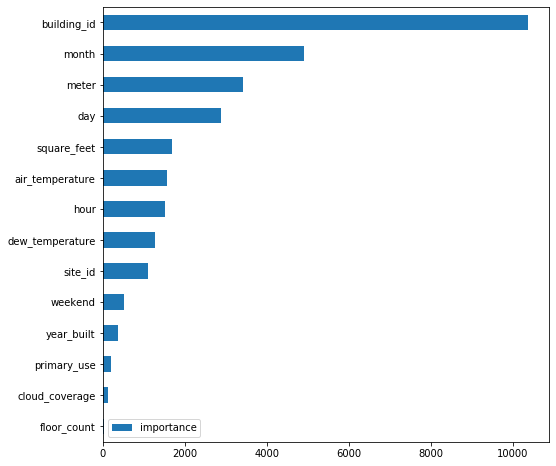

In [86]:
plot_feature_importance(models_base_3)

### MAKE PREDICTIONS LGBM MODEL

In [50]:
def gen_test_prediction(training_dict, path = './submissions/lgbm/', file_name='submission_v1_'):
    
    models = training_dict['models']
    categorical = training_dict['categories']
    numerical = training_dict['numerical']
    dict_LabelEncoder = training_dict['labels']
    
    test_df = prep_test_data(categorical, numerical, dict_LabelEncoder)
    
    #run the model and generate predictions
    i=0
    res=[]
    step_size = 50000
    folds = len(models)
    for j in range(int(np.ceil(test_df.shape[0]/50000))):
        res.append(np.expm1(sum([model.predict(test_df.iloc[i:i+step_size]) for model in models])/folds))
        i+=step_size
        print('Step: {} of 833'.format(j))
    
    #combine results
    res = np.concatenate(res)
    
    #set file name for submission
    submission_name = file_name + strftime("%Y%m%d-%H%m", gmtime()) + ".csv"
    
    submission = pd.read_csv('/Users/ns/code/nicholasjhana/ashrae-energy-prediction/data/sample_submission.csv')

    submission['meter_reading'] = res
    submission.loc[submission['meter_reading']<0, 'meter_reading'] = 0
    submission.to_csv(path + submission_name, index=False)
    
    return submission

In [49]:
sub_base_3 = gen_test_prediction(models_base_3, path = './submissions/lgbm/', file_name='submission_v2_')

inital load (41697600, 4)
after building df load (41697600, 9)
after weather load (41697600, 18)
Memory usage of properties dataframe is : 6203.485107421875  MB
******************************
Column:  row_id
dtype before:  int64
min for this col:  0
max for this col:  41697599
dtype after:  uint32
******************************
******************************
Column:  building_id
dtype before:  int64
min for this col:  0
max for this col:  1448
dtype after:  uint16
******************************
******************************
Column:  meter
dtype before:  int64
min for this col:  0
max for this col:  3
dtype after:  uint8
******************************
******************************
Column:  site_id
dtype before:  int64
min for this col:  0
max for this col:  15
dtype after:  uint8
******************************
******************************
Column:  primary_use
dtype before:  int64
min for this col:  0
max for this col:  15
dtype after:  uint8
******************************
**********

Step: 362
Step: 363
Step: 364
Step: 365
Step: 366
Step: 367
Step: 368
Step: 369
Step: 370
Step: 371
Step: 372
Step: 373
Step: 374
Step: 375
Step: 376
Step: 377
Step: 378
Step: 379
Step: 380
Step: 381
Step: 382
Step: 383
Step: 384
Step: 385
Step: 386
Step: 387
Step: 388
Step: 389
Step: 390
Step: 391
Step: 392
Step: 393
Step: 394
Step: 395
Step: 396
Step: 397
Step: 398
Step: 399
Step: 400
Step: 401
Step: 402
Step: 403
Step: 404
Step: 405
Step: 406
Step: 407
Step: 408
Step: 409
Step: 410
Step: 411
Step: 412
Step: 413
Step: 414
Step: 415
Step: 416
Step: 417
Step: 418
Step: 419
Step: 420
Step: 421
Step: 422
Step: 423
Step: 424
Step: 425
Step: 426
Step: 427
Step: 428
Step: 429
Step: 430
Step: 431
Step: 432
Step: 433
Step: 434
Step: 435
Step: 436
Step: 437
Step: 438
Step: 439
Step: 440
Step: 441
Step: 442
Step: 443
Step: 444
Step: 445
Step: 446
Step: 447
Step: 448
Step: 449
Step: 450
Step: 451
Step: 452
Step: 453
Step: 454
Step: 455
Step: 456
Step: 457
Step: 458
Step: 459
Step: 460
Step: 461


In [254]:
#from tqdm import tqdm
folds = 5
i=0
res=[]
step_size = 50000
for j in range(int(np.ceil(test_df.shape[0]/50000))):
    res.append(np.expm1(sum([model.predict(test_df.iloc[i:i+step_size]) for model in models])/folds))
    i+=step_size
    
res = np.concatenate(res)

In [26]:
len(res), len(submission)

NameError: name 'submission' is not defined

In [256]:
submission = pd.read_csv('/Users/ns/code/nicholasjhana/ashrae-energy-prediction/data/sample_submission.csv')

submission['meter_reading'] = res
submission.loc[submission['meter_reading']<0, 'meter_reading'] = 0
submission.to_csv('./submissions/lgbm/submission_v3_fe_copy.csv', index=False)
submission

,row_id,meter_reading
0,0,95.332216
1,1,14.969151
2,2,34.011147
3,3,23.028960
4,4,15.507085
...,...,...
41697595,41697595,15.733225
41697596,41697596,15.733225
41697597,41697597,15.733225
41697598,41697598,15.733225


## FEATURE ANALYSIS

In [78]:
train_df, target, dict_LabelEncoder = prep_train_data(categorical,
                                                      numerical,
                                                      label_cols
                                                     )

inital load (20216100, 4)
after building df load (20216100, 9)
after weather load (20216100, 18)
Memory usage of properties dataframe is : 3007.613754272461  MB
******************************
Column:  building_id
dtype before:  int64
min for this col:  0
max for this col:  1448
dtype after:  uint16
******************************
******************************
Column:  meter
dtype before:  int64
min for this col:  0
max for this col:  3
dtype after:  uint8
******************************
******************************
Column:  meter_reading
dtype before:  float64
min for this col:  0.0
max for this col:  21904700.0
dtype after:  float32
******************************
******************************
Column:  site_id
dtype before:  int64
min for this col:  0
max for this col:  15
dtype after:  uint8
******************************
******************************
Column:  primary_use
dtype before:  int64
min for this col:  0
max for this col:  15
dtype after:  uint8
***************************

In [62]:
weather = pd.read_csv("/Users/ns/code/nicholasjhana/ashrae-energy-prediction/data/weather_train.csv")

In [65]:
import matplotlib.pyplot as plt

def plot_hist(df, col):
    fig, ax = plt.subplots(1,1,figsize=(8,7))
    df[col].plot(kind='hist', ax=ax)
#plot_hist('year_built')

col_views = ['square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed']

Questions:
1. Is this 1.2 * E7 because of the number of observations? Or is it because of the number of buildings?
2. This seems like a good candidate for a categorical transform. I.e. on the basis of generic energy consumption standards. Assuming buildings in 2000s are more efficient than 1950-1980 etc.

In [67]:
weather.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


### Air temperature

### Cloud Coverage

### Dew temperature

Do not want to do log transform. Left skew but mostly guassian.

Another idea... correlate to setpoints for indoor airconditioning/heating?

In [128]:
weather['dew_temperature'].value_counts()

 10.0    2759
 12.8    2201
 5.0     2196
 13.3    2193
 11.7    2188
         ... 
-16.5       2
-18.5       2
-30.6       2
-21.6       2
-27.4       2
Name: dew_temperature, Length: 523, dtype: int64

In [129]:
weather.groupby(['site_id','day','month'])['dew_temperature'].mean()

KeyError: 'day'

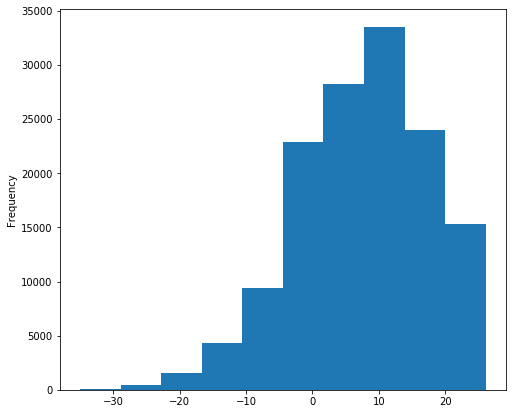

In [70]:
plot_hist(weather, 'dew_temperature')

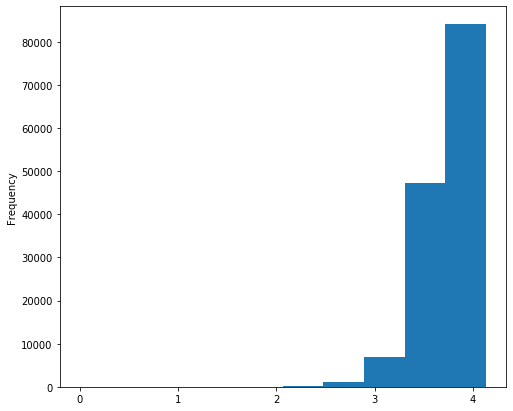

In [72]:
dew_mean = weather['dew_temperature'].mean()
weather['dew_temperature'] = weather['dew_temperature'].fillna(dew_mean)
weather['dew_temp_log'] = np.log(weather['dew_temperature'] - (weather['dew_temperature'].min()-1))
plot_hist(weather, 'dew_temp_log')

### 1Hour precipitation

This looks pretty bad...

In [76]:
weather.precip_depth_1_hr.value_counts(dropna=False)

 0.0      77910
 NaN      50289
-1.0       5780
 3.0       1469
 5.0        720
          ...  
 109.0        1
 147.0        1
 78.0         1
 180.0        1
 73.0         1
Name: precip_depth_1_hr, Length: 129, dtype: int64

In [226]:
weather['precip_depth_1_hr'].apply(lambda x: x if x>=0 else 0)

0.0      133979
3.0        1469
5.0         720
2.0         517
8.0         447
          ...  
140.0         1
333.0         1
175.0         1
73.0          1
180.0         1
Name: precip_depth_1_hr, Length: 127, dtype: int64

In [215]:
weather['precip_depth_1_hr'].value_counts(dropna=False)

 0.0      77910
 NaN      50289
-1.0       5780
 3.0       1469
 5.0        720
          ...  
 109.0        1
 147.0        1
 78.0         1
 180.0        1
 73.0         1
Name: precip_depth_1_hr, Length: 129, dtype: int64

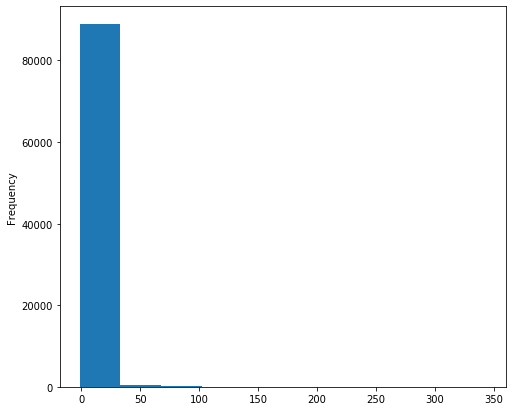

In [74]:
plot_hist(weather, 'precip_depth_1_hr')

## Wind Speed

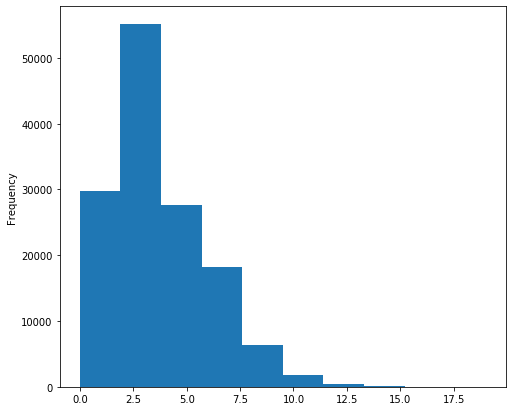

In [95]:
plot_hist(weather, 'wind_speed')

In [125]:
weather['sea_level_pressure'].value_counts

<bound method IndexOpsMixin.value_counts of 0         1019.7
1         1020.2
2         1020.2
3         1020.1
4         1020.0
           ...  
139768       NaN
139769    1007.4
139770    1007.5
139771    1008.0
139772    1008.5
Name: sea_level_pressure, Length: 139773, dtype: float64>

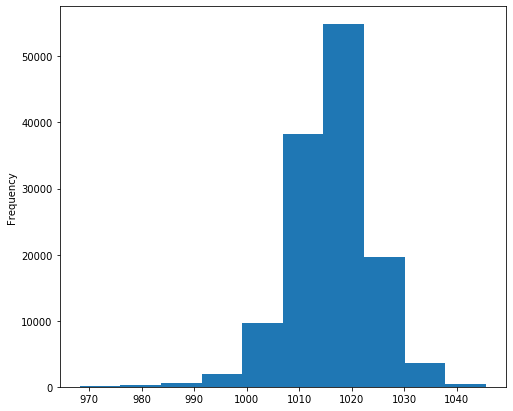

In [77]:
plot_hist(weather, 'sea_level_pressure')

In [208]:
weather['cloud_coverage'].value_counts()

0.0    33871
2.0    13585
4.0    10241
8.0     3531
6.0     3521
7.0     3485
1.0      713
3.0      608
5.0      526
9.0      519
Name: cloud_coverage, dtype: int64

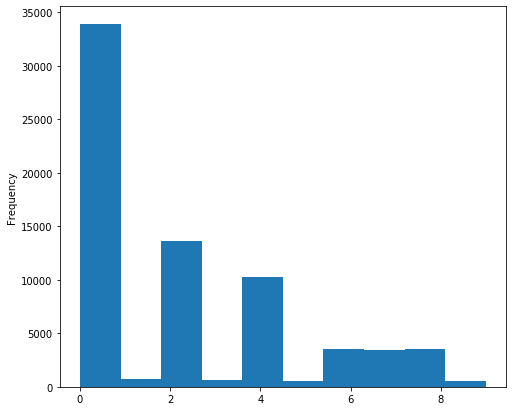

In [107]:
plot_hist(weather, 'cloud_coverage')

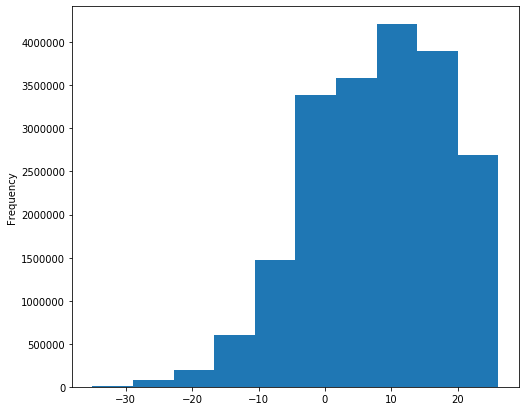

In [45]:
plot_hist('dew_temperature')

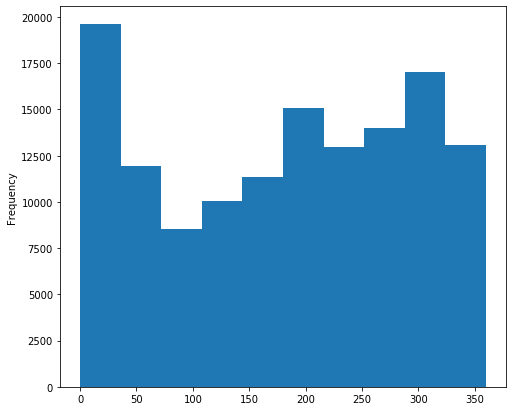

In [108]:
plot_hist(weather, 'wind_direction')

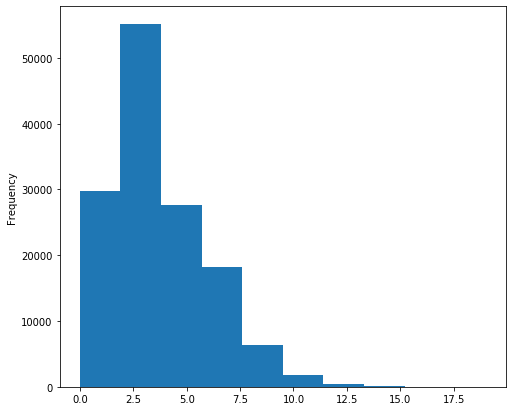

In [109]:
plot_hist(weather, 'wind_speed')

In [110]:
weather.columns

Index(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'dew_temp_log'],
      dtype='object')

## Correlations

In [21]:
from sklearn.feature_selection import SelectKBest, f_classif
#Suppose, we select 5 features with top 5 Fisher scores
selector = SelectKBest(f_classif, k = 5)
#New dataframe with the selected features for later use in the classifier. fit() method works too, if you want only the feature names and their corresponding scores
X_new = selector.fit_transform(train_df, target)
names = tain_df.columns.values[selector.get_support()]
scores = selector.scores_[selector.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

NameError: name 'target' is not defined

In [53]:
#correlation with no binning or transformations
train_df.corr()['meter_reading']

building_id           0.008848
meter                 0.017710
meter_reading         1.000000
site_id               0.011996
square_feet           0.024347
year_built            0.113314
floor_count           0.128825
air_temperature      -0.004132
cloud_coverage        0.006024
dew_temperature      -0.003330
precip_depth_1_hr     0.000509
sea_level_pressure   -0.004220
wind_direction       -0.000078
wind_speed            0.005452
dew_temp             -0.004007
Name: meter_reading, dtype: float64

In [31]:
train.isnull().sum()

building_id                  0
meter                        0
timestamp                    0
meter_reading                0
site_id                      0
primary_use                  0
square_feet                  0
year_built            12113306
floor_count           16630052
air_temperature           6163
cloud_coverage         8734870
dew_temperature           9645
precip_depth_1_hr      3658528
sea_level_pressure     1141174
wind_direction         1358553
wind_speed               53181
dew_temp                  9645
dtype: int64

In [67]:
train['floor_count'].value_counts().sort_index()

single       1622007
low          1229617
mid           488011
high-rise     155918
Name: floor_count, dtype: int64

In [62]:
weather_train = pd.read_csv("/Users/ns/code/nicholasjhana/ashrae-energy-prediction/data/weather_train.csv")
weather_train.isnull().sum()
#weather_train['wind_speed'] = np.log1p(weather_train['wind_speed'])

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64

In [63]:
weather_train.shape

(139773, 9)

In [69]:
check = weather_train.wind_speed.fillna(0)
check.isnull().sum()

0

In [51]:
wind_speed = weather_train.wind_speed.dropna()
dew_temp = weather_train.dew_temperature.dropna()

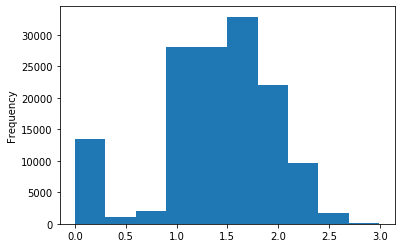

In [52]:
wind_speed_log = np.log1p(wind_speed)
wind_speed.plot(kind='hist')

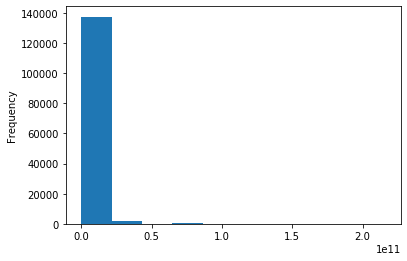

In [53]:
dew_temp = np.expm1(dew_temp)
dew_temp.plot(kind='hist')

### Things to try
1. Log transform the following floor_count, square_feet, year_built
2. Is cloud coverage only two values? What about wind direction?
3. 

In [4]:
lgbm.__version__

'2.3.0'

In [12]:
%cd ..
!ls -l

/Users/ns/code/nicholasjhana/ashrae-energy-prediction
total 24
-rw-r--r--   1 ns  staff  4636 21 Oct 21:10 README.md
-rw-r--r--   1 ns  staff  2286 17 Nov 19:25 conda_environment.yml
drwxr-xr-x  10 ns  staff   320 17 Nov 19:21 data
drwxr-xr-x   5 ns  staff   160 17 Nov 19:36 notebooks


In [13]:
pd.read_csv('/Users/ns/code/nicholasjhana/ashrae-energy-prediction/data/building_metadata.csv')

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN
...,...,...,...,...,...,...
1444,15,1444,Entertainment/public assembly,19619,1914.0,NaN
1445,15,1445,Education,4298,NaN,NaN
1446,15,1446,Entertainment/public assembly,11265,1997.0,NaN
1447,15,1447,Lodging/residential,29775,2001.0,NaN


# NOTES
1. Number of floors classifications is taken from this paper: https://www.tandfonline.com/doi/full/10.1080/09613218.2018.1479927
2.